Demontis, Ambra, et al. "Why do adversarial attacks transfer? Explaining transferability of evasion and poisoning attacks." 28th USENIX security symposium (USENIX security 19). 2019.

To reproduce the results, use this code from SecML library. Instead of the toy example with CDLRandomBlobs, you can load MNIST dataset from MNIST data loader and you can get DREBIN dataset here. 


Paper:https://www.usenix.org/system/files/sec19-demontis.pdf


Useful links from the projectfile:

https://secml.readthedocs.io/en/v0.15/tutorials/13-Android-Malware-Detection.html

https://secml.readthedocs.io/en/v0.15/secml.data.loader.html#module-secml.data.loader.c_dataloader_mnist

https://figshare.com/articles/dataset/Android_malware_dataset_for_machine_learning_2/5854653

20-25 min for the presentation + 5-10 for questions

Don't show code on the slides

Present content of the paper + show what we have done with some graphs or tables

Be curious - look for why results are different or play with some variables

**Remember to run it in the conda - I have python 3.10 and I need 3.8 for secml**

https://secml.readthedocs.io/en/v0.15/tutorials/04-Transferability.html

This link seems more useful than the one with malware detection.

In [26]:
#Load the dataset
random_state = 999
'''

n_features = 2  # Number of features
n_samples = 2250  # Number of samples
centers = [[-2, 0], [2, -2], [2, 2]]  # Centers of the clusters
cluster_std = 0.8  # Standard deviation of the clusters

from secml.data.loader import CDLRandomBlobs
dataset = CDLRandomBlobs(n_features=n_features,
                         centers=centers,
                         cluster_std=cluster_std,
                         n_samples=n_samples,
                         random_state=random_state).load()
'''

from secml.data.loader import CDataLoaderMNIST
mnist_loader = CDataLoaderMNIST()
tr = mnist_loader.load(ds='training', digits=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9))
ts = mnist_loader.load(ds='testing', digits=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9))

#This dataset is not normalized, so it has to be normalized similarly to blobs

''' Blob code
n_tr = 1000  # Number of training set samples
n_ts = 250  # Number of test set samples

# Split in training and test.
from secml.data.splitter import CTrainTestSplit
splitter = CTrainTestSplit(
    train_size=2 * n_tr, test_size=n_ts, random_state=random_state)
tr, ts = splitter.split(dataset)
'''

# Normalize the data
from secml.ml.features import CNormalizerMinMax
nmz = CNormalizerMinMax()
tr.X = nmz.fit_transform(tr.X)
ts.X = nmz.transform(ts.X)


''' Blob code
# Generate 2 training datasets for surrogate and target classifiers
tr1 = tr[:n_tr, :]  # Source classifier training set
tr2 = tr[n_tr:, :]  # Target classifier training set
'''

# Get the size of the training dataset
num_samples, num_features = tr.X.shape
tr1 = tr[:int(num_samples/2), :]  # Source classifier training set
tr2 = tr[int(num_samples/2):, :]  # Target classifier training set

In [9]:
from collections import namedtuple
CLF = namedtuple('CLF', 'clf_name clf xval_parameters')

from secml.ml.classifiers.multiclass import CClassifierMulticlassOVA
# Binary classifiers
from secml.ml.classifiers import CClassifierSVM, CClassifierSGD
# Natively-multiclass classifiers
from secml.ml.classifiers import CClassifierKNN, CClassifierDecisionTree, CClassifierRandomForest

# Let's create a 3-Fold data splitter
from secml.data.splitter import CDataSplitterKFold
xval_splitter = CDataSplitterKFold(num_folds=3, random_state=random_state)

# Metric to use for training and performance evaluation
from secml.ml.peval.metrics import CMetricAccuracy
metric = CMetricAccuracy()

surr_clf = CLF(
    clf_name='SVM Linear H',
    clf=CClassifierMulticlassOVA(CClassifierSVM, kernel='linear'),
    xval_parameters={'C': [100]})

''' I have just one set of values - the one from the paper
print("Estimating the best training parameters of the surrogate classifier...")
best_params = surr_clf.clf.estimate_parameters(
    dataset=tr1,
    parameters=surr_clf.xval_parameters,
    splitter=xval_splitter,
    metric=metric,
    perf_evaluator='xval'
)
print("The best training parameters of the surrogate classifier are: ",
      [(k, best_params[k]) for k in sorted(best_params)])
'''

print("\nTraining the surrogate classifiers...")

surr_clf.clf.fit(tr1.X, tr1.Y)

y_pred = surr_clf.clf.predict(ts.X)

acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)

print("Accuracy of the surrogate classifier on test set: {:.2%}".format(acc))


''' 
    #Something is wrong with this one
    CLF(clf_name='Logistic (SGD)',
        clf=CClassifierMulticlassOVA(
            CClassifierSGD, regularizer='l2', loss='loss',
            random_state=random_state),
        xval_parameters={'alpha': [1e-6, 1e-5, 1e-4]}),
     
    #Not used in a paper
    CLF(clf_name='kNN',
        clf=CClassifierKNN(),
        xval_parameters={'n_neighbors': [30, 40, 50]}),
'''

print("\nTraining the target classifiers...")


Training the surrogate classifiers...
Accuracy of the surrogate classifier on test set: 93.00%

Training the target classifiers...


In [5]:
target_clf_list = [
    CLF(
        clf_name='SVM Linear H',
        clf=CClassifierMulticlassOVA(CClassifierSVM, kernel='linear'),
        xval_parameters={'C': [100]}),
    CLF(
        clf_name='SVM Linear L',
        clf=CClassifierMulticlassOVA(CClassifierSVM, kernel='linear'),
        xval_parameters={'C': [0.1]}),
]

'''Run one by one or my computer will die 
    CLF(clf_name='SVM RBF H',
        clf=CClassifierMulticlassOVA(CClassifierSVM, kernel='rbf'),
        xval_parameters={'C': [100],  'kernel.gamma': [0.01]}),
    CLF(clf_name='SVM RBF L',
        clf=CClassifierMulticlassOVA(CClassifierSVM, kernel='rbf'),
        xval_parameters={'C': [1],  'kernel.gamma': [0.01]}),
    CLF(clf_name='Decision Tree H',
        clf=CClassifierDecisionTree(random_state=random_state),
        xval_parameters={'max_depth': [16]}),
    CLF(clf_name='Decision Tree L',
        clf=CClassifierDecisionTree(random_state=random_state),
        xval_parameters={'max_depth': [8]}),
    CLF(clf_name='Random Forest H',
        clf=CClassifierRandomForest(random_state=random_state),
        xval_parameters={'n_estimators': [30], 'max_depth': [16]}),
    CLF(clf_name='Random Forest L',
        clf=CClassifierRandomForest(random_state=random_state),
        xval_parameters={'n_estimators': [30], 'max_depth': [8]}),
'''

print("\nClassifiers trained...")


Classifiers trained...


In [6]:
for i, test_case in enumerate(target_clf_list):
    clf = test_case.clf
    xval_params = test_case.xval_parameters

    '''No best parameters for now, I use data from the papers
    print("\nEstimating the best training parameters of {:} ..."
          "".format(test_case.clf_name))
    
    best_params = clf.estimate_parameters(
        dataset=tr2, parameters=xval_params, splitter=xval_splitter,
        metric='accuracy', perf_evaluator='xval')
            
    print("The best parameters for '{:}' are: ".format(test_case.clf_name),
          [(k, best_params[k]) for k in sorted(best_params)])

    '''
    print("Training of {:} ...".format(test_case.clf_name))
    clf.fit(tr2.X, tr2.Y)

    # Predictions on test set and performance evaluation
    y_pred = clf.predict(ts.X)
    acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)

    print("Classifier: {:}\tAccuracy: {:.2%}".format(test_case.clf_name, acc))

Training of SVM Linear H ...
Classifier: SVM Linear H	Accuracy: 91.70%
Training of SVM Linear L ...
Classifier: SVM Linear L	Accuracy: 91.70%


Change "loss = log" to "loss = log_loss" in the:

 CLF(clf_name='Logistic (SGD)',
        clf=CClassifierMulticlassOVA(
            CClassifierSGD, regularizer='l2', loss='log_loss',
            random_state=random_state),
        xval_parameters={'alpha': [1e-6, 1e-5, 1e-4]}),
        
This change causes:  no class of type `log_loss` is a subclass of 'CLoss' from module 'secml.ml.classifiers.loss.c_loss'

In [48]:
#It would take me around 170 hours to run evasion attack on the default configuration. 

noise_type = 'l2'  # Type of perturbation 'l1' or 'l2'
dmax = 0.4  # Maximum perturbation
lb, ub = 0, 1  # Bounds of the attack space. Can be set to `None` for unbounded
y_target = 2  # `error-specific` attack. None for `error-generic`

# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 1e-1,
    'eta_min': 0.1,
    'eta_max': None,
    'max_iter': 25,
    'eps': 5
}

from secml.adv.attacks.evasion import CAttackEvasionPGDLS
pgd_ls_attack = CAttackEvasionPGDLS(
    classifier=surr_clf.clf,
    double_init_ds=tr1,
    double_init=False,
    distance=noise_type,
    dmax=dmax,
    lb=lb, ub=ub,
    solver_params=solver_params,
    y_target=y_target)

#Again it is very computationally intensive, run a test on a small subset (1%) and check time
smallerts = ts[100:200, :]

# Run the evasion attack on x0
print("Attack started...")
y_pred, scores, adv_ds, f_obj = pgd_ls_attack.run(smallerts.X, smallerts.Y)
print("Attack complete!")

Attack started...
Attack complete!


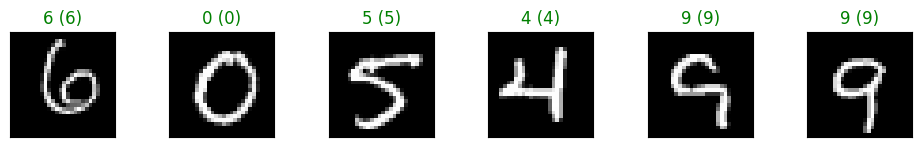

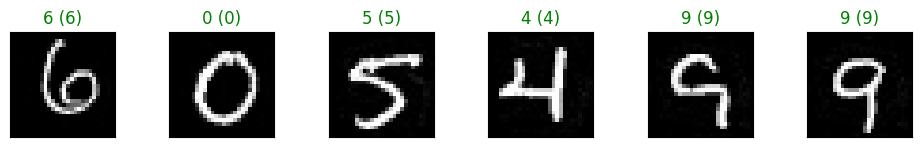

In [47]:
#Just visualise the attack

from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline
digits=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
# Let's define a convenience function to easily plot the MNIST dataset
def show_digits(samples, preds, labels, digs, n_display=6):
    samples = samples.atleast_2d()
    n_display = min(n_display, samples.shape[0])
    fig = CFigure(width=n_display*2, height=3)
    for idx in range(n_display):
        fig.subplot(2, n_display, idx+1)
        fig.sp.xticks([])
        fig.sp.yticks([])
        fig.sp.imshow(samples[idx, :].reshape((28, 28)), cmap='gray')
        fig.sp.title("{} ({})".format(digits[labels[idx].item()], digs[preds[idx].item()]),
                     color=("green" if labels[idx].item()==preds[idx].item() else "red"))
    fig.show()

show_digits(smallerts.X, clf.predict(smallerts.X), smallerts.Y, digits)
show_digits(adv_ds.X, clf.predict(adv_ds.X), adv_ds.Y, digits)


Testing transferability of SVM Linear H
Test error (no attack): 6.00%

Testing transferability of SVM Linear L
Test error (no attack): 6.00%


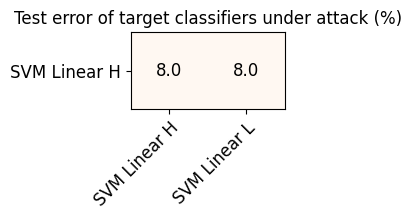


Average transfer rate: 8.00%


In [34]:
# Metric to use for testing transferability
from secml.ml.peval.metrics import CMetricTestError
metric = CMetricTestError()

trans_error = []
transfer_rate = 0.0
for target_clf in target_clf_list:

    print("\nTesting transferability of {:}".format(target_clf.clf_name))

    origin_error = metric.performance_score(
            y_true=smallerts.Y, y_pred=target_clf.clf.predict(smallerts.X))

    print("Test error (no attack): {:.2%}".format(origin_error))

    trans_error_clf = metric.performance_score(
        y_true=smallerts.Y, y_pred=target_clf.clf.predict(adv_ds.X))

    trans_error.append(trans_error_clf)
    transfer_rate += trans_error_clf

# Computing the transfer rate
transfer_rate /= len(target_clf_list)

from secml.array import CArray
trans_acc = CArray(trans_error) * 100  # Show results in percentage

from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

fig = CFigure(height=1)
a = fig.sp.imshow(trans_acc.reshape((1, len(target_clf_list))),
                  cmap='Oranges', interpolation='nearest',
                  alpha=.65, vmin=60, vmax=70)

fig.sp.xticks(CArray.arange((len(target_clf_list))))
fig.sp.xticklabels([c.clf_name for c in target_clf_list],
                   rotation=45, ha="right", rotation_mode="anchor")
fig.sp.yticks([0])
fig.sp.yticklabels([surr_clf.clf_name])

for i in range(len(target_clf_list)):
    fig.sp.text(i, 0, trans_acc[i].round(2).item(), va='center', ha='center')

fig.sp.title("Test error of target classifiers under attack (%)")

fig.show()

print("\nAverage transfer rate: {:.2%}".format(transfer_rate))

Here I changed hardcoded 6 elements into len(target_clf_list), to test at lower number of classifiers at the time (or otherwise my computer would not handle it). Moreover, if we were sticking strictly to the paper it would be 12 classifiers in total (H and L version for each).